# Card Tempering Detection

O propósito do projeto é detectar um *cartão falsificado* usando **visão computacional**. Isso pode ajudar diferentes organizações 
a identificarem se o documento de identificação providenciado pelos empregados e consumidores é **original ou não.** 

*Para este projeto, nós vamos calcular a similaridade de um cartão Original Pan e o fornecido pelo usuário*

In [1]:
#Importação dos pacotes

from skimage.metrics import structural_similarity
import imutils
import cv2
from PIL import Image
import requests

In [2]:
!mkdir card_tempering
!mkdir card_tempering\image

Já existe uma subpasta ou um arquivo card_tempering.
Já existe uma subpasta ou um arquivo card_tempering\image.


In [3]:
#Abrir e visualizar imagem

'''
Projeto original: https://www.thestatesman.com/wp-content/uploads/2019/07/pan-card.jpg
Projeto falso: https://assets1.cleartax-cdn.com/s/img/20170526124335/Pan4.png
'''

original = Image.open(requests.get('https://i.imgur.com/DnAnLWI.jpg', stream=True).raw)
tampered = Image.open(requests.get('https://i.pinimg.com/originals/84/ad/9d/84ad9de16ea393b5363efe11d648a8fb.jpg', stream=True).raw)

#Outras imagens de teste
'''
https://rogertakemiya.com.br/wp-content/uploads/2017/06/Pasted-4.png
https://i.pinimg.com/474x/f0/bf/d6/f0bfd62b6227f528735f291abe3ad1c4.jpg
'''

'\nhttps://rogertakemiya.com.br/wp-content/uploads/2017/06/Pasted-4.png\nhttps://i.pinimg.com/474x/f0/bf/d6/f0bfd62b6227f528735f291abe3ad1c4.jpg\n'

### Processamento de imagens

In [4]:
# Atribuindo formato original
print('Original image format : ', original.format)
print('Tampered image format : ', tampered.format)

# Tamanho da imagem, em pixels. O tamanho é fornecido como uma tupla (largura, altura)
print('Original image size : ', original.size)
print('Tampered image size : ', tampered.size)

Original image format :  JPEG
Tampered image format :  JPEG
Original image size :  (1591, 1200)
Tampered image size :  (960, 738)


Redimensionando as imagens

In [5]:
#RG original
original = original.resize((250,160))
print(original.size)
original.save('card_tempering/image/original.png') #Salvando imagem

#RG falso
tampered = tampered.resize((250,160))
print(tampered.size)
tampered.save('card_tempering/image/tampered.png') #Salvando imagem

(250, 160)
(250, 160)


Checando as imagens

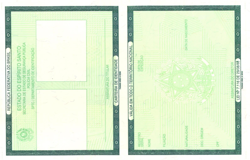

In [6]:
original

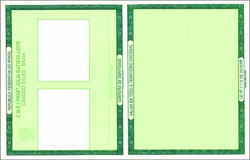

In [7]:
tampered

Processando imagens para escala monocromática, pois a *grayscale* só tem um canal, enquanto a colorida é **RGB**, portando, assim, três.

In [8]:
# Lendo imagens com opencv

original = cv2.imread('card_tempering/image/original.png')
tampered = cv2.imread('card_tempering/image/tampered.png')

In [9]:
# Convertendo para grayscale
original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
tampered_gray = cv2.cvtColor(tampered, cv2.COLOR_BGR2GRAY)

In [10]:
original_gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [254, 251, 253, ..., 255, 254, 254],
       ...,
       [254, 252, 250, ..., 255, 255, 255],
       [254, 254, 252, ..., 255, 254, 255],
       [255, 255, 253, ..., 255, 255, 255]], dtype=uint8)

In [11]:
tampered_gray

array([[140, 185, 182, ..., 183, 183, 138],
       [171, 254, 252, ..., 254, 255, 172],
       [171, 254, 251, ..., 254, 253, 170],
       ...,
       [167, 253, 252, ..., 254, 254, 170],
       [171, 255, 254, ..., 255, 255, 172],
       [139, 189, 187, ..., 187, 189, 140]], dtype=uint8)

### Modelando

In [12]:
# Calcular o Structural Similarity Index (SSIM) entre as duas imagens
(score, diff) = structural_similarity(original_gray, tampered_gray, full=True)
diff = (diff * 255).astype('uint8')
print('SSIM: {}'.format(score))

SSIM: 0.6933983793390552


*O Structural Similarity Index nos ajuda a determinar exatamente onde, em coordenadas x,y, estão as diferenças entre as imagens. Quanto menor o **SSIM score**, menor a similaridade.*

In [13]:
# Calculando treshhold e contornos

thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

*O **Threshold** adaptativo é uma função da visão computacional que é guardada em formato de array. Essa função transforma a imagem monocromática em uma imagem binária.*

*A função **findContours** pega essa imagem binária e analisa os formatos contidos.* 

In [14]:
cnts

(array([[[  0,   0]],
 
        [[  0,   1]],
 
        [[  1,   1]],
 
        [[  2,   2]],
 
        [[  2,  23]],
 
        [[  1,  24]],
 
        [[  0,  23]],
 
        [[  0,  10]],
 
        [[  0, 153]],
 
        [[  1, 154]],
 
        [[  0, 155]],
 
        [[  1, 156]],
 
        [[  1, 159]],
 
        [[249, 159]],
 
        [[249,   0]]], dtype=int32),)

Agora, vamos delimitar uma caixa retangular para os contornos e desenhar as boxes de ambas as imagens, representando a diferença entre elas

In [15]:
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(tampered, (x, y), (x + w, y + h), (0, 0, 255), 2)

Original Format Image


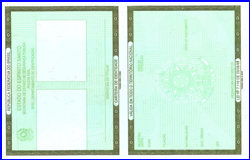

In [16]:
# Display original image with contour
print('Original Format Image')
Image.fromarray(original)

Tampered Format Image


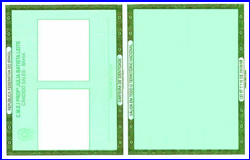

In [17]:
# Display tampered image with contour
print('Tampered Format Image')
Image.fromarray(tampered)

Different Image


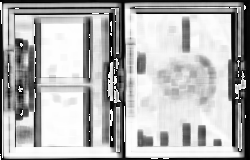

In [18]:
# Display difference image with black
print('Different Image')
Image.fromarray(diff)

Threshold Image


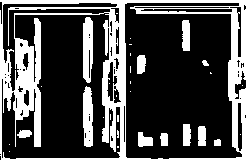

In [19]:
# Display threshold image with white
print('Threshold Image')
Image.fromarray(thresh)

## Conclusão

Encontrar a similaridade estrutural das imagens nos ajuda a encontrar as diferenças entre elas.
Similarmente, encontrar o threshold e os contornos baseados nesse threshold das imagens convertidas em escala binária monocromática também possibilita analises e reconhecimento visual.

Com nosso *SSIM* de **69%**, não podemos dizer que a imagem providenciada foi alterada ou, ao menos, despadronizada.

Os testes aqui foram feitos usando imagens extremamente parecidas de um RG. O projeto original foi feito utilizando cartões de identificação indianos.